### **Load Packages**

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle

In [41]:
torch.manual_seed(42)

### **Load Datasets**
- Filtered df
- Embeddings from ESM2
- Smiles representations from RDKit Morgan Fingerprints

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load in the cleaned parquet dataframe
# Use your google drive path where the parquet file is. Or copy path from colab.
df = pd.read_parquet("/content/drive/MyDrive/DeepLearningProject/base_cleaned_df.parquet")
df.head(2)

,reactant_set_id,drug_smiles,drug_name,protein_name,ic50,protein_sequence,ic50_numeric
0,143,Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...,"US9447092, 3",Cytochrome P450 3A4,>50000,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,50000.0
1,145,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,"US9447087, 24::2-(benzo[d]oxazol-2-ylamino)-4'...",Galactokinase,6676.9,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,6676.9


In [5]:
# Load embeddings ~ change file path
base_path = "/content/drive/MyDrive/DeepLearningProject/all_embeddings/"

files = [
    "embeddings250k.npy",
    "embeddings500k.npy",
    "embeddings750K.npy",
    "embeddings1M.npy",
    "embeddings_1.1M.npy",
    "embeddings_1.25M.npy",
    "embeddings_1.5M.npy",
    "embeddings1750k_end.npy",
    "embeddings_2Mend.npy",
    "embeddings2M_after.npy",
]

embeddings = [
    np.load(base_path + f, allow_pickle=True) for f in files
]

In [6]:
# concatenate into a single object array
all_embeddings = np.concatenate(embeddings, axis=0)

print(all_embeddings.shape)       # matches num of rows in the df!
print(type(all_embeddings))
print(type(all_embeddings[0]))

(2074074, 320)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
# add embeddings to the df
df["protein_embedding"] = list(all_embeddings)

In [8]:
from numpy._core import numeric
# load smiles strings and add it to df
numeric_smiles = np.load("/content/drive/MyDrive/DeepLearningProject/numeric_smiles_compressed.npz", allow_pickle=True)['arr_list']
df["numeric_smiles"] = numeric_smiles
df.head(2)

,reactant_set_id,drug_smiles,drug_name,protein_name,ic50,protein_sequence,ic50_numeric,protein_embedding,numeric_smiles
0,143,Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...,"US9447092, 3",Cytochrome P450 3A4,>50000,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,50000.0,"[0.01256, -0.081, 0.2876, 0.07025, 0.1588, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,145,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,"US9447087, 24::2-(benzo[d]oxazol-2-ylamino)-4'...",Galactokinase,6676.9,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,6676.9,"[-0.1868, -0.004528, 0.153, 0.1824, 0.1621, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **Preprocess Dataset**

In [12]:
# log-transform ic50_numeric values ~ avoid log(0) by adding a small constant
df['ic50_log'] = -np.log10((df['ic50_numeric'] * 1e-9) + 1e-12)

print(df["ic50_numeric"].describe())
print('\n',df["ic50_log"].describe())

count    2.074074e+06
mean     1.922054e+08
std      1.211706e+11
min      0.000000e+00
25%      2.640000e+01
50%      3.000000e+02
75%      5.290000e+03
max      1.000000e+14
Name: ic50_numeric, dtype: float64

 count    2.074074e+06
mean     6.484217e+00
std      1.502993e+00
min     -5.000000e+00
25%      5.276544e+00
50%      6.522877e+00
75%      7.578380e+00
max      1.200000e+01
Name: ic50_log, dtype: float64


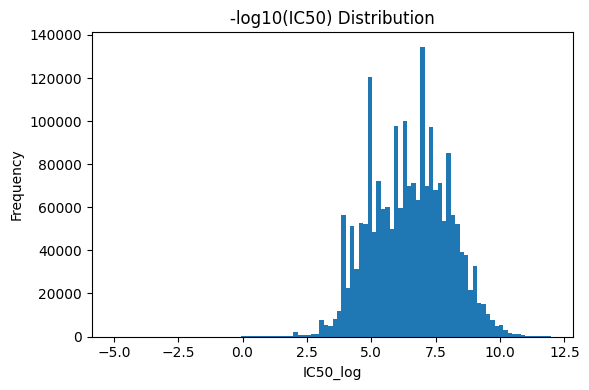

In [40]:
plt.figure(figsize=(6,4))
plt.hist(df['ic50_log'], bins=100)
plt.title('-log10(IC50) Distribution')
plt.xlabel('IC50_log')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
# remove rows with NA values
df_clean = df.dropna(subset=["numeric_smiles"])

print(df_clean.shape)
print(df_clean.isna().sum())

(2073278, 10)
reactant_set_id      0
drug_smiles          0
drug_name            0
protein_name         0
ic50                 0
protein_sequence     0
ic50_numeric         0
protein_embedding    0
numeric_smiles       0
ic50_log             0
dtype: int64


### **Prepare the Data**

In [14]:
# Convert embeddings from lists to numpy arrays if necessary
X_drug = np.stack(df_clean["numeric_smiles"].to_numpy())        # shape (n_samples, drug_dim)
X_protein = np.stack(df_clean["protein_embedding"].to_numpy())  # shape (n_samples, protein_dim)
y = df_clean["ic50_log"].to_numpy()                             # shape (n_samples,)

# Standardize the protein embeddings
scaler = StandardScaler()
protein_scaled = scaler.fit_transform(X_protein)

print(X_drug.shape)
print(protein_scaled.shape)
print(y.shape)

# Concatenate drug + protein embeddings as input
X = np.concatenate([X_drug, protein_scaled], axis=1)
y = y.reshape(-1, 1)  # make it 2D for regression

(2073278, 2048)
(2073278, 320)
(2073278,)


In [44]:
# Saves the scalar
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### **Create Dataset and DataLoader for Train/Test Sets**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [28]:
batch_size = 512

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **Define the Model**

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [22]:
class SimpleANN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # Regression output
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = SimpleANN(input_dim).to(device) # model on device ready
model

SimpleANN(
  (model): Sequential(
    (0): Linear(in_features=2368, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

### **Train and Test the Model**

In [23]:
# Early Stopping logic
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [24]:
#early_stopper = EarlyStopping(patience=3, min_delta=0.0001)

train_losses = []
test_losses = []
criterion = nn.MSELoss()
epochs = 36
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(epochs):
    # ----- Training -----
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device) # batches on device ready
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # ----- Testing -----
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_X.size(0)

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

   # early_stopper(avg_test_loss)
   # if early_stopper.stop:
   #     print("Early stopping triggered!")
   #     break


Epoch 1/25, Train Loss: 1.2304, Test Loss: 0.9066
Epoch 2/25, Train Loss: 0.9016, Test Loss: 0.7674
Epoch 3/25, Train Loss: 0.8059, Test Loss: 0.7148
Epoch 4/25, Train Loss: 0.7439, Test Loss: 0.6817
Epoch 5/25, Train Loss: 0.6980, Test Loss: 0.6595
Epoch 6/25, Train Loss: 0.6600, Test Loss: 0.6304
Epoch 7/25, Train Loss: 0.6304, Test Loss: 0.6124
Epoch 8/25, Train Loss: 0.6046, Test Loss: 0.5977
Epoch 9/25, Train Loss: 0.5822, Test Loss: 0.6019
Epoch 10/25, Train Loss: 0.5644, Test Loss: 0.5826
Epoch 11/25, Train Loss: 0.5455, Test Loss: 0.5853
Epoch 12/25, Train Loss: 0.5288, Test Loss: 0.5653
Epoch 13/25, Train Loss: 0.5154, Test Loss: 0.5587
Epoch 14/25, Train Loss: 0.5037, Test Loss: 0.5505
Epoch 15/25, Train Loss: 0.4906, Test Loss: 0.5446
Epoch 16/25, Train Loss: 0.4792, Test Loss: 0.5477
Epoch 17/25, Train Loss: 0.4682, Test Loss: 0.5338
Epoch 18/25, Train Loss: 0.4580, Test Loss: 0.5276
Epoch 19/25, Train Loss: 0.4487, Test Loss: 0.5239
Epoch 20/25, Train Loss: 0.4388, Test Lo

### **Model Performance**

In [25]:
# RMSE calculation
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        all_preds.append(preds.cpu())
        all_targets.append(batch_y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)


rmse = torch.sqrt(torch.mean((all_preds - all_targets) ** 2))
print("Test RMSE:", rmse.item())

Test RMSE: 0.7092851400375366


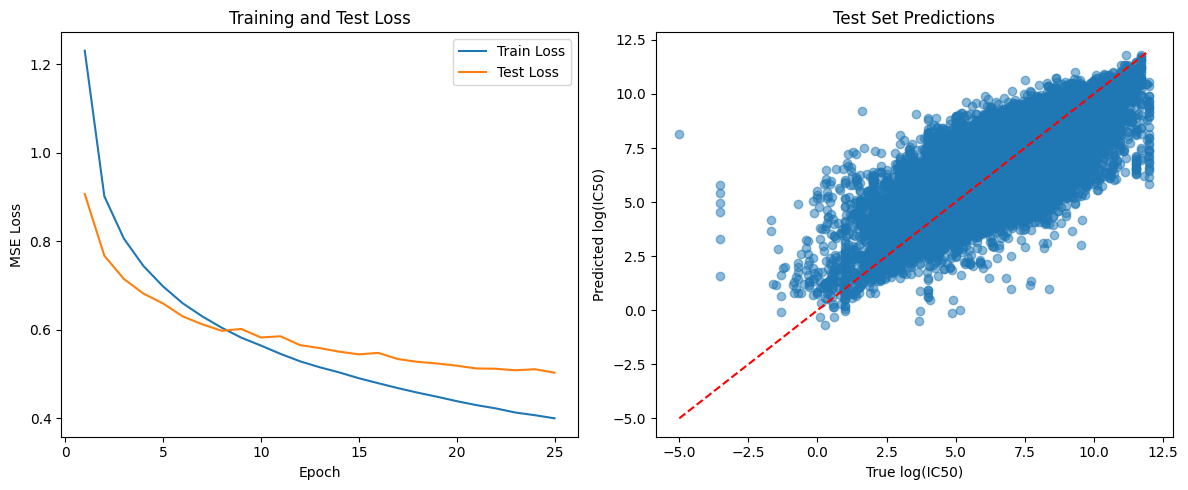

In [34]:
# --- Loss curves ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(test_losses)+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Test Loss")
plt.legend()

# --- Predicted vs True ---
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test.to(device)).cpu().numpy()

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True log(IC50)")
plt.ylabel("Predicted log(IC50)")
plt.title("Test Set Predictions")

plt.tight_layout()
plt.savefig("arch3.png", dpi=300, bbox_inches="tight")
plt.show()

### **Save the model**

In [31]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [33]:
from google.colab import files
files.download("model_state_dict.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>